In [9]:
import os 
import random
import pickle
from copy import deepcopy

import networkx as nx 
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pyomo as pyo
import highspy 
import pandas as pd
from pulp import *
from warehouse_model.layout import Layout
from warehouse_model.simulation import Order, OrderPickEvent, run_simulation, Agent, s_shape
import datetime
from warehouse_model.simulation import sim_loop
from warehouse_model.graph_tools import viz_graph
from utils import render_warehouse, calc_product_freq
from data.instance_loader import InstanceLoader

In [10]:
def gen_pos(G: nx.Graph):
    pos_dict = {}
    for node in G.nodes():
        pos_dict[node] = np.array([node[0], node[1], node[2]])
    return pos_dict

In [11]:
h = highspy.Highs()

In [12]:
instance = InstanceLoader()
instance.load_instance()

In [13]:
instance.orders[0]

[[0, 1], [1, 1]]

In [14]:
instance.skus[instance.orders[0][0][0]]

{'aisle': 0, 'cell': 1, 'quantity': 1, 'side': 'left'}

In [15]:
instance.general_info

{'NAME': 'Pr_20_1_20_Store1_01.txt',
 'TYPE': 'Order_batching',
 'COMMENT': 'Bahï¿½eci and ï¿½ncan (2021)',
 'PICKER_CAPACITY': '20',
 'LAYOUT': 'single-block',
 'NUM_AISLES': '10',
 'NUM_CELLS': '10',
 'DEPOT_AISLE': '0',
 'DEPOT_LOCATION': 'bottom',
 'DISTANCE_AISLE_TO_AISLE': '2.4',
 'DISTANCE_CELL_TO_CELL': '1',
 'DISTANCE_TOP_TO_CELL': '1',
 'DISTANCE_BOTTOM_TO_CELL': '1',
 'DISTANCE_TOP_OR_BOTTOM_TO_DEPOT': '0'}

In [16]:
layout_info = instance.general_info
aisles = int(layout_info["NUM_AISLES"])
locations = int(layout_info["NUM_CELLS"])
inter_cell_dist = float(layout_info["DISTANCE_CELL_TO_CELL"])
inter_aisle_dist = float(layout_info["DISTANCE_AISLE_TO_AISLE"])
G = nx.Graph()
G.add_node((0,0,0)) #depot
G.add_node((1,1,0)) #first aisle
G.add_node((1,2+locations,0)) #first aisle
last_mid = (1,1,0)
for l in range(locations):
    location_left= (0, l+2, 0)
    location_right = (2, l+2, 0)
    location_mid = (1, l+2, 0)

    G.add_node(location_left)
    G.add_node(location_right)
    G.add_node(location_mid)

    G.add_edge(location_left, location_mid, weight=1)
    G.add_edge(location_right, location_mid, weight=1)

    G.add_edge(last_mid, location_mid, weight=1)
    last_mid = location_mid
G.add_edge(last_mid, (1,2+locations,0), weight=1)
    
start = 1
last_aisle_start = (1,1,0)
last_aisle_end = (1,2+locations,0)
for a in range(aisles-1):
    start += 3
    aisle_start = (start, 1, 0)
    aisle_end = (start, 2+locations, 0)
    G.add_node(aisle_start)
    G.add_node(aisle_end)
    # if a > 0:
    last_mid = aisle_start
    for l in range(locations):
        location_left = (start-1, l+2, 0)
        location_right = (start+1, l+2, 0)
        location_mid = (start, l+2, 0)

        G.add_node(location_left)
        G.add_node(location_right)
        G.add_node(location_mid)

        G.add_edge(location_left, location_mid, weight=1)
        G.add_edge(location_right, location_mid, weight=1)

        G.add_edge(last_mid, location_mid, weight=1)
        last_mid = location_mid

    G.add_edge(last_mid, aisle_end, weight=1)

    #G.add_edge(aisle_start, aisle_end, weight=(locations+1)*inter_cell_dist)
    G.add_edge(last_aisle_start, aisle_start, weight=inter_aisle_dist)
    G.add_edge(last_aisle_end, aisle_end, weight=inter_aisle_dist)
    last_aisle_start = aisle_start
    last_aisle_end = aisle_end



In [17]:
aisles = 4
locations = 5
inter_cell_dist = 1
inter_aisle_dist = 3
G = nx.Graph()
#G.add_node((0,0,0)) #depot
G.add_node((1,1,0)) #first aisle
G.add_node((1,2+locations,0)) #first aisle
last_mid = (1,1,0)
for l in range(locations):
    #location_left= (0, l+2, 0)
    #location_right = (2, l+2, 0)
    location_mid = (1, l+2, 0)

    #G.add_node(location_left)
    #G.add_node(location_right)
    G.add_node(location_mid)

    # G.add_edge(location_left, location_mid, weight=1)
    # G.add_edge(location_right, location_mid, weight=1)

    G.add_edge(last_mid, location_mid, weight=1)
    last_mid = location_mid
G.add_edge(last_mid, (1,2+locations,0), weight=1)
    
start = 1
last_aisle_start = (1,1,0)
last_aisle_end = (1,2+locations,0)
for a in range(aisles-1):
    start += 3
    aisle_start = (start, 1, 0)
    aisle_end = (start, 2+locations, 0)
    G.add_node(aisle_start)
    G.add_node(aisle_end)
    # if a > 0:
    last_mid = aisle_start
    for l in range(locations):
        # location_left = (start-1, l+2, 0)
        # location_right = (start+1, l+2, 0)
        location_mid = (start, l+2, 0)

        # G.add_node(location_left)
        # G.add_node(location_right)
        G.add_node(location_mid)

        # G.add_edge(location_left, location_mid, weight=1)
        # G.add_edge(location_right, location_mid, weight=1)

        G.add_edge(last_mid, location_mid, weight=1)
        last_mid = location_mid

    G.add_edge(last_mid, aisle_end, weight=1)

    #G.add_edge(aisle_start, aisle_end, weight=(locations+1)*inter_cell_dist)
    G.add_edge(last_aisle_start, aisle_start, weight=inter_aisle_dist)
    G.add_edge(last_aisle_end, aisle_end, weight=inter_aisle_dist)
    last_aisle_start = aisle_start
    last_aisle_end = aisle_end



In [18]:
layout_info

{'NAME': 'Pr_20_1_20_Store1_01.txt',
 'TYPE': 'Order_batching',
 'COMMENT': 'Bahï¿½eci and ï¿½ncan (2021)',
 'PICKER_CAPACITY': '20',
 'LAYOUT': 'single-block',
 'NUM_AISLES': '10',
 'NUM_CELLS': '10',
 'DEPOT_AISLE': '0',
 'DEPOT_LOCATION': 'bottom',
 'DISTANCE_AISLE_TO_AISLE': '2.4',
 'DISTANCE_CELL_TO_CELL': '1',
 'DISTANCE_TOP_TO_CELL': '1',
 'DISTANCE_BOTTOM_TO_CELL': '1',
 'DISTANCE_TOP_OR_BOTTOM_TO_DEPOT': '0'}

In [19]:
layout_info = instance.general_info
aisles = int(layout_info["NUM_AISLES"])
locations = int(layout_info["NUM_CELLS"])
inter_cell_dist = float(layout_info["DISTANCE_CELL_TO_CELL"])
inter_aisle_dist = float(layout_info["DISTANCE_AISLE_TO_AISLE"])
G = nx.Graph()
#depot=(int(layout_info["DEPOT_AISLE"]),0,0)
#G.add_node(depot) #depot
    
start = 0
last_aisle_start = (start,0,0)
last_aisle_end = (start,locations-1,0)
#G.add_edge(depot, (7, 1, 0), weight=1.5)
for a in range(aisles):
    aisle_start = (start, 0, 0)
    aisle_end = (start, locations-1, 0)
    G.add_node(aisle_start)
    G.add_node(aisle_end)
    # if a > 0:
    last_mid = aisle_start
    for l in range(locations):
        # location_left = (start-1, l+2, 0)
        # location_right = (start+1, l+2, 0)
        location_mid = (start, l, 0)

        # G.add_node(location_left)
        # G.add_node(location_right)
        G.add_node(location_mid)

        # G.add_edge(location_left, location_mid, weight=1)
        # G.add_edge(location_right, location_mid, weight=1)

        G.add_edge(last_mid, location_mid, weight=inter_cell_dist)
        last_mid = location_mid

    G.add_edge(last_mid, aisle_end, weight=1)

    G.add_edge(last_aisle_start, aisle_start, weight=inter_aisle_dist)
    G.add_edge(last_aisle_end, aisle_end, weight=inter_aisle_dist)
    last_aisle_start = aisle_start
    last_aisle_end = aisle_end
    start += 3

In [20]:
pos_dict = gen_pos(G)

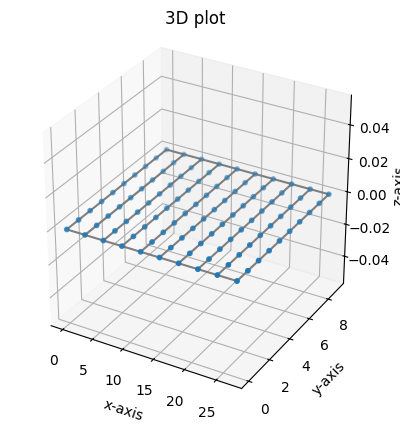

In [21]:
viz_graph(G, pos_dict)

In [22]:
layout_info

{'NAME': 'Pr_20_1_20_Store1_01.txt',
 'TYPE': 'Order_batching',
 'COMMENT': 'Bahï¿½eci and ï¿½ncan (2021)',
 'PICKER_CAPACITY': '20',
 'LAYOUT': 'single-block',
 'NUM_AISLES': '10',
 'NUM_CELLS': '10',
 'DEPOT_AISLE': '0',
 'DEPOT_LOCATION': 'bottom',
 'DISTANCE_AISLE_TO_AISLE': '2.4',
 'DISTANCE_CELL_TO_CELL': '1',
 'DISTANCE_TOP_TO_CELL': '1',
 'DISTANCE_BOTTOM_TO_CELL': '1',
 'DISTANCE_TOP_OR_BOTTOM_TO_DEPOT': '0'}

In [23]:
len(instance.orders)

8

In [24]:
instance.articles

{0: {'weight': 1},
 1: {'weight': 1},
 2: {'weight': 1},
 3: {'weight': 1},
 4: {'weight': 1},
 5: {'weight': 1},
 6: {'weight': 1},
 7: {'weight': 1},
 8: {'weight': 1},
 9: {'weight': 1},
 10: {'weight': 1},
 11: {'weight': 1},
 12: {'weight': 1},
 13: {'weight': 1},
 14: {'weight': 1},
 15: {'weight': 1},
 16: {'weight': 1},
 17: {'weight': 1}}

In [25]:
product_frequency = {i: 0 for i in instance.articles}
for order in instance.orders:
    print(order)
    for orderline in order:
        product_frequency[orderline[0]] += 1

[[0, 1], [1, 1]]
[[2, 1], [3, 1], [4, 1]]
[[5, 1], [6, 1]]
[[7, 1], [8, 1], [9, 1]]
[[10, 1], [11, 1]]
[[12, 1], [13, 1], [14, 1]]
[[15, 1], [11, 1]]
[[16, 1], [17, 2]]


In [26]:
from collections import defaultdict

product_pairs_frequency = defaultdict(lambda: defaultdict(int))

# Iterate through each order list
for order in instance.orders:
    # Generate all possible pairs of products in the order
    for i in range(len(order)):
        for j in range(i + 1, len(order)):
            product_pairs_frequency[order[i][0]][order[j][0]] += 1
            product_pairs_frequency[order[j][0]][order[i][0]] += 1

In [27]:
product_pairs_frequency

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {1: 1}),
             1: defaultdict(int, {0: 1}),
             2: defaultdict(int, {3: 1, 4: 1}),
             3: defaultdict(int, {2: 1, 4: 1}),
             4: defaultdict(int, {2: 1, 3: 1}),
             5: defaultdict(int, {6: 1}),
             6: defaultdict(int, {5: 1}),
             7: defaultdict(int, {8: 1, 9: 1}),
             8: defaultdict(int, {7: 1, 9: 1}),
             9: defaultdict(int, {7: 1, 8: 1}),
             10: defaultdict(int, {11: 1}),
             11: defaultdict(int, {10: 1, 15: 1}),
             12: defaultdict(int, {13: 1, 14: 1}),
             13: defaultdict(int, {12: 1, 14: 1}),
             14: defaultdict(int, {12: 1, 13: 1}),
             15: defaultdict(int, {11: 1}),
             16: defaultdict(int, {17: 1}),
             17: defaultdict(int, {16: 1})})

In [28]:
product_pairs_frequency[0][0]

0

In [29]:
product_pairs_frequency = {}

# Collect all unique products
unique_products = set()
for order in instance.orders:
    for product in order:
        unique_products.add(product[0])

# Initialize all possible pairs with zero, including self-pairs
for product1 in unique_products:
    product_pairs_frequency[product1] = {}
    for product2 in unique_products:
        product_pairs_frequency[product1][product2] = 0

# Iterate through each order list
for order in instance.orders:
    # Generate all possible pairs of products in the order, including self-pairs
    for i in range(len(order)):
        for j in range(i, len(order)):
            product1, product2 = order[i][0], order[j][0]

            # Update the frequency for product1 -> product2
            product_pairs_frequency[product1][product2] += 1
            if product1 != product2:
                # Update the frequency for product2 -> product1, but only if they are different
                product_pairs_frequency[product2][product1] += 1

In [30]:
import pyomo.environ as pyo

# Create a model
model = pyo.ConcreteModel()
n_orders = len(instance.orders)
max_batches = 11
# Define the set of values
model.orders = pyo.RangeSet(1, n_orders)
model.batches = pyo.RangeSet(1, max_batches)
model.tours = pyo.RangeSet(1, max_batches)
  
# Parameter a, read from the file 'a.txt'
# Assuming 'a.txt' contains one value per line for a[1] to a[11]
with open('a.txt') as f:
    a_values = [float(line.strip()) for line in f]

# Capacities, assuming each batch has the same capacity of 10
capacities = [10 for _ in range(max_batches)] 

# Initialize parameter a
model.order_weight = pyo.Param(model.orders, initialize=dict(enumerate(a_values, start=1)))
model.capacities = pyo.Param(model.batches, initialize=dict(enumerate(capacities, start=1)))

# Binary variable x -> order i in batch j?
model.x = pyo.Var(model.orders, model.batches, domain=pyo.Binary)

# Binary variable y -> batch j used?
model.y = pyo.Var(model.batches, domain=pyo.Binary) 

# Binary variable y -> tour k used?
#model.z = pyo.Var(model.tours, domain=pyo.Binary)

# Binary variable tour -> order i in tour k?
#model.tour = pyo.Var(model.orders, model.tours, domain=pyo.Binary)

# Objective: Minimize the number of batches used
def objective(model):
    return pyo.summation(model.y) 

model.objective = pyo.Objective(rule=objective, sense=pyo.minimize)

# Constraint: Each order assigned to exactly one batch
def constraint_one_batch_max(model, order):
    return sum(model.x[order, batch] for batch in model.batches) == 1

model.constraint_one_batch_max = pyo.Constraint(model.orders, rule=constraint_one_batch_max)

# Constraint: Batch capacity not exceeded
def constraint_capacity(model, batch):
    return sum(model.x[order, batch] * model.order_weight[order] for order in model.orders) <= model.capacities[batch] * model.y[batch]

model.constraint_capacity = pyo.Constraint(model.batches, rule=constraint_capacity)

# Constraint: Orders assigned to one tour
# def constraint_one_tour_max(model, order):
#     return sum(model.tour[order, tour] for tour in model.batches) == 1

# model.constraint_one_tour_max = pyo.Constraint(model.orders, rule=constraint_one_tour_max)

FileNotFoundError: [Errno 2] No such file or directory: 'a.txt'

In [46]:
layout_info = instance.general_info
aisles = int(layout_info["NUM_AISLES"])
locations = int(layout_info["NUM_CELLS"])
inter_cell_dist = float(layout_info["DISTANCE_CELL_TO_CELL"])
inter_aisle_dist = float(layout_info["DISTANCE_AISLE_TO_AISLE"])
G = nx.Graph()
depot=(int(layout_info["DEPOT_AISLE"]),0,0)
G.add_node(depot) #depot
    
start = 1
last_aisle_start = (start,1,0)
last_aisle_end = (start,2+locations,0)
G.add_edge(depot, (7, 1, 0), weight=1.5)
for a in range(aisles):
    aisle_start = (start, 1, 0)
    aisle_end = (start, 2+locations, 0)
    G.add_node(aisle_start)
    G.add_node(aisle_end)
    # if a > 0:
    last_mid = aisle_start
    for l in range(locations):
        location_left = (start-1, l+2, 0)
        location_right = (start+1, l+2, 0)
        location_mid = (start, l+2, 0)

        G.add_node(location_left)
        G.add_node(location_right)
        G.add_node(location_mid)

        G.add_edge(location_left, location_mid, weight=1)
        G.add_edge(location_right, location_mid, weight=1)

        G.add_edge(last_mid, location_mid, weight=inter_cell_dist)
        last_mid = location_mid

    G.add_edge(last_mid, aisle_end, weight=1)

    G.add_edge(last_aisle_start, aisle_start, weight=inter_aisle_dist)
    G.add_edge(last_aisle_end, aisle_end, weight=inter_aisle_dist)
    last_aisle_start = aisle_start
    last_aisle_end = aisle_end
    start += 3

In [47]:
pos_dict = gen_pos(G)

In [48]:
pos_dict

{(0, 0, 0): array([0, 0, 0]),
 (7, 1, 0): array([7, 1, 0]),
 (1, 1, 0): array([1, 1, 0]),
 (1, 12, 0): array([ 1, 12,  0]),
 (0, 2, 0): array([0, 2, 0]),
 (2, 2, 0): array([2, 2, 0]),
 (1, 2, 0): array([1, 2, 0]),
 (0, 3, 0): array([0, 3, 0]),
 (2, 3, 0): array([2, 3, 0]),
 (1, 3, 0): array([1, 3, 0]),
 (0, 4, 0): array([0, 4, 0]),
 (2, 4, 0): array([2, 4, 0]),
 (1, 4, 0): array([1, 4, 0]),
 (0, 5, 0): array([0, 5, 0]),
 (2, 5, 0): array([2, 5, 0]),
 (1, 5, 0): array([1, 5, 0]),
 (0, 6, 0): array([0, 6, 0]),
 (2, 6, 0): array([2, 6, 0]),
 (1, 6, 0): array([1, 6, 0]),
 (0, 7, 0): array([0, 7, 0]),
 (2, 7, 0): array([2, 7, 0]),
 (1, 7, 0): array([1, 7, 0]),
 (0, 8, 0): array([0, 8, 0]),
 (2, 8, 0): array([2, 8, 0]),
 (1, 8, 0): array([1, 8, 0]),
 (0, 9, 0): array([0, 9, 0]),
 (2, 9, 0): array([2, 9, 0]),
 (1, 9, 0): array([1, 9, 0]),
 (0, 10, 0): array([ 0, 10,  0]),
 (2, 10, 0): array([ 2, 10,  0]),
 (1, 10, 0): array([ 1, 10,  0]),
 (0, 11, 0): array([ 0, 11,  0]),
 (2, 11, 0): array([

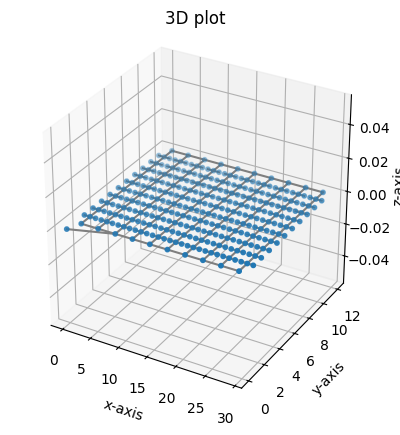

In [49]:
viz_graph(G, pos_dict)

In [50]:
import pyomo.environ as pyo 

In [51]:
aisles

10

In [52]:
instance.skus

{6: {'aisle': 0, 'cell': 5, 'quantity': 1, 'side': 'left'},
 15: {'aisle': 0, 'cell': 3, 'quantity': 1, 'side': 'left'},
 7: {'aisle': 0, 'cell': 2, 'quantity': 1, 'side': 'left'},
 0: {'aisle': 0, 'cell': 1, 'quantity': 1, 'side': 'left'},
 14: {'aisle': 2, 'cell': 9, 'quantity': 1, 'side': 'left'},
 1: {'aisle': 2, 'cell': 8, 'quantity': 1, 'side': 'left'},
 13: {'aisle': 2, 'cell': 5, 'quantity': 1, 'side': 'left'},
 10: {'aisle': 3, 'cell': 8, 'quantity': 1, 'side': 'left'},
 3: {'aisle': 3, 'cell': 4, 'quantity': 1, 'side': 'left'},
 16: {'aisle': 4, 'cell': 8, 'quantity': 1, 'side': 'left'},
 4: {'aisle': 4, 'cell': 6, 'quantity': 1, 'side': 'left'},
 12: {'aisle': 4, 'cell': 0, 'quantity': 1, 'side': 'left'},
 17: {'aisle': 5, 'cell': 8, 'quantity': 2, 'side': 'left'},
 8: {'aisle': 5, 'cell': 3, 'quantity': 1, 'side': 'left'},
 2: {'aisle': 6, 'cell': 4, 'quantity': 1, 'side': 'left'},
 5: {'aisle': 8, 'cell': 4, 'quantity': 1, 'side': 'left'},
 11: {'aisle': 9, 'cell': 4, 'qua

In [53]:
dik = {}
for order_idx, order in enumerate(instance.orders):
    dik[order_idx] = []
    for line in order:
        item = line[0]
        quantity = line[1]
        aisle = instance.skus[item]["aisle"]
        cell = instance.skus[item]["cell"]
        side = instance.skus[item]["side"]
        dik[order_idx].append((aisle, cell))
        
    

In [54]:
instance.general_info

{'NAME': 'Pr_20_1_20_Store1_01.txt',
 'TYPE': 'Order_batching',
 'COMMENT': 'Bahï¿½eci and ï¿½ncan (2021)',
 'PICKER_CAPACITY': '20',
 'LAYOUT': 'single-block',
 'NUM_AISLES': '10',
 'NUM_CELLS': '10',
 'DEPOT_AISLE': '0',
 'DEPOT_LOCATION': 'bottom',
 'DISTANCE_AISLE_TO_AISLE': '2.4',
 'DISTANCE_CELL_TO_CELL': '1',
 'DISTANCE_TOP_TO_CELL': '1',
 'DISTANCE_BOTTOM_TO_CELL': '1',
 'DISTANCE_TOP_OR_BOTTOM_TO_DEPOT': '0'}

In [55]:
dik = {}
for order in range(len(instance.orders)):
    for aisle in range(int(instance.general_info["NUM_AISLES"])):
        dik[(order+1, aisle)] = 0

In [56]:
max_aisle_dist = {}
order_weights = {}
for order_idx, order in enumerate(instance.orders):
    max_aisle_dist[order_idx+1] = {}
    order_weights[order_idx+1] = []
    for line in order:
        item = line[0]
        quantity = line[1]
        aisle = instance.skus[item]["aisle"]
        cell = instance.skus[item]["cell"]
        side = instance.skus[item]["side"]
        if aisle not in max_aisle_dist[order_idx+1].keys():
            max_aisle_dist[order_idx+1][aisle] = []
        max_aisle_dist[order_idx+1][aisle].append(cell)
        order_weights[order_idx+1].append(instance.articles[item]["weight"])

In [57]:
order_weights

{1: [1, 1],
 2: [1, 1, 1],
 3: [1, 1],
 4: [1, 1, 1],
 5: [1, 1],
 6: [1, 1, 1],
 7: [1, 1],
 8: [1, 1]}

In [58]:
for order in max_aisle_dist.keys():
    for aisle in max_aisle_dist[order].keys():
        max_dist = max(max_aisle_dist[order][aisle])
        dik[(order, aisle)] = max_dist

In [59]:
instance.general_info

{'NAME': 'Pr_20_1_20_Store1_01.txt',
 'TYPE': 'Order_batching',
 'COMMENT': 'Bahï¿½eci and ï¿½ncan (2021)',
 'PICKER_CAPACITY': '20',
 'LAYOUT': 'single-block',
 'NUM_AISLES': '10',
 'NUM_CELLS': '10',
 'DEPOT_AISLE': '0',
 'DEPOT_LOCATION': 'bottom',
 'DISTANCE_AISLE_TO_AISLE': '2.4',
 'DISTANCE_CELL_TO_CELL': '1',
 'DISTANCE_TOP_TO_CELL': '1',
 'DISTANCE_BOTTOM_TO_CELL': '1',
 'DISTANCE_TOP_OR_BOTTOM_TO_DEPOT': '0'}

In [60]:
len(instance.orders)

8

In [ ]:
n_orders = len(instance.orders)
n_batches = 7
capacity = int(instance.general_info["PICKER_CAPACITY"])
aisles = int(instance.general_info["NUM_AISLES"])
inter_aisle_dist = float(instance.general_info["DISTANCE_AISLE_TO_AISLE"])
aisle_length = (int(instance.general_info["NUM_CELLS"]) * 
                int(instance.general_info["DISTANCE_CELL_TO_CELL"]))

model = pyo.ConcreteModel("BATCHING_TRAVERSAL")
model.Aisles = pyo.RangeSet(0, aisles-1) 
model.Orders = pyo.RangeSet(1, n_orders)
model.Batches = pyo.RangeSet(1, n_batches)

weights = []
for order in order_weights.keys():
    weights.append(sum(order_weights[order]))
items_per_order = []
for order in order_weights.keys():
    items_per_order.append(len(order_weights[order]))
model.mi = pyo.Param(model.Orders, initialize=dict(enumerate(items_per_order, start=1)))
model.dik = pyo.Param(model.Orders, model.Aisles, initialize=dik)
model.M = pyo.Param(within=pyo.NonNegativeReals, initialize=1000)
model.vj = pyo.Var(model.Batches, domain=pyo.Integers)

model.yjk = pyo.Var(model.Batches, model.Aisles, domain=pyo.Binary)
model.pjk = pyo.Var(model.Batches, model.Aisles, domain=pyo.Binary)

model.cj = pyo.Var(model.Batches, domain=pyo.Binary)

model.xij = pyo.Var(model.Orders, model.Batches, domain=pyo.Binary)
model.hjR = pyo.Var(model.Batches, domain=pyo.PositiveReals)
model.hjL = pyo.Var(model.Batches, domain=pyo.PositiveReals)
model.ujk = pyo.Var(model.Batches, model.Aisles, domain=pyo.PositiveReals)

M = 1000

def objective(model):
    return 2 * pyo.quicksum(
        model.ujk[j,k] for j in model.Batches for k in model.Aisles
    ) 
    + 2 * pyo.quicksum(
        model.hjR[j] * model.hjL[j] for j in model.Batches
    )
    + 2 * aisle_length * pyo.quicksum(
        model.vj[j] - model.cj[j] for j in model.Batches
    )

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)

def constraint_batch_assignment(model, i_order):
    return pyo.quicksum(model.xij[i_order,j] for j in model.Batches) == 1
model.constraint_batch_assignment = pyo.Constraint(model.Orders, rule=constraint_batch_assignment)

def constraint_batch_guarantee(model, i_order, j):
    return model.xij[i_order,j] <= model.xij[j,j]
model.constraint_batch_guarantee = pyo.Constraint(model.Orders, model.Batches, rule=constraint_batch_guarantee)

def constraint_batch_capacity(model, j):
    return pyo.quicksum(model.mi[i_order] * model.xij[i_order,j] for i_order in model.Orders) <= capacity
model.constraint_batch_capacity = pyo.Constraint(model.Batches, rule=constraint_batch_capacity)

def constraint_aisle_visit(model, j, k):
    return model.yjk[j,k] == pyo.quicksum(model.dik[i,k] * model.xij[i,j] for i in model.Orders)
model.constraint_aisle_visit = pyo.Constraint(model.Batches, model.Aisles, rule=constraint_aisle_visit)

def constraint_aisle_visit_upper(model, j, k):
    return pyo.quicksum(model.dik[i,k] * model.xij[i,j] for i in model.Orders) <= model.M * model.yjk[j,k]
model.constraint_aisle_visit_upper = pyo.Constraint(model.Batches, model.Aisles, rule=constraint_aisle_visit_upper)

def constraint_horizontal_distance_1(model, j, k):
    return ((k+1) - k) * inter_aisle_dist * model.yjk[j,k] <= model.hjR[j]
model.constraint_horizontal_distance_1 = pyo.Constraint(model.Batches, model.Aisles, rule=constraint_horizontal_distance_1)

def constraint_horizontal_distance_2(model, j, k):
    return ((k+1) - k) * inter_aisle_dist * model.yjk[j,k] <= model.hjL[j]
model.constraint_horizontal_distance_2 = pyo.Constraint(model.Batches, model.Aisles, rule=constraint_horizontal_distance_2)

def constraint_batch_visit(model, j):
    return pyo.quicksum(model.yjk[j,k] for k in model.Aisles) + model.cj[j] == 2 * model.vj[j]
model.constraint_batch_visit = pyo.Constraint(model.Batches, rule=constraint_batch_visit)

In [78]:
instance.general_info["PICKER_CAPACITY"]

'20'

In [92]:
n_orders = len(instance.orders)
n_batches = 2
#capacity = int(instance.general_info["PICKER_CAPACITY"])
capacity = 3
aisles = int(instance.general_info["NUM_AISLES"])
inter_aisle_dist = float(instance.general_info["DISTANCE_AISLE_TO_AISLE"])
aisle_length = (int(instance.general_info["NUM_CELLS"]) * 
                int(instance.general_info["DISTANCE_CELL_TO_CELL"]))

model = pyo.ConcreteModel("BATCHING_TRAVERSAL")
model.Aisles = pyo.RangeSet(0, aisles-1) 
model.Orders = pyo.RangeSet(1, n_orders)
model.Batches = pyo.RangeSet(1, n_batches)

weights = []
for order in order_weights.keys():
    weights.append(sum(order_weights[order]))
items_per_order = []
for order in order_weights.keys():
    items_per_order.append(len(order_weights[order]))
model.mi = pyo.Param(model.Orders, initialize=dict(enumerate(items_per_order, start=1)))
model.dik = pyo.Param(model.Orders, model.Aisles, initialize=dik)
model.M = pyo.Param(within=pyo.NonNegativeReals, initialize=1000)
model.vj = pyo.Var(model.Batches, domain=pyo.Integers)

model.yjk = pyo.Var(model.Batches, model.Aisles, domain=pyo.Binary)
model.pjk = pyo.Var(model.Batches, model.Aisles, domain=pyo.Binary)

model.cj = pyo.Var(model.Batches, domain=pyo.Binary)

model.xij = pyo.Var(model.Orders, model.Batches, domain=pyo.Binary)
model.hjR = pyo.Var(model.Batches, domain=pyo.PositiveReals)
model.hjL = pyo.Var(model.Batches, domain=pyo.PositiveReals)
model.ujk = pyo.Var(model.Batches, model.Aisles, domain=pyo.PositiveReals)

M = 1000

def objective(model):
    return 2 * pyo.quicksum(
        model.ujk[j,k] for j in model.Batches for k in model.Aisles
) 
+ 2 * pyo.quicksum(
    model.hjR[j] * model.hjL[j] for j in model.Batches
)
+ 2 * aisle_length * pyo.quicksum(
    model.vj[j] - model.cj[j] for j in model.Batches
)

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)

def constraint_batch_assignment(model, i_order):
    return pyo.quicksum(model.xij[i_order,j] for j in model.Batches) == 1
model.constraint_batch_assignment = pyo.Constraint(model.Orders, rule=constraint_batch_assignment)

def constraint_batch_capacity(model, i_order):
    return pyo.quicksum(model.mi[i_order]*model.xij[i_order,j] for j in model.Batches) <= capacity
model.constraint_batch_capacity = pyo.Constraint(model.Orders, rule=constraint_batch_capacity)

def constraint_batch_guarantee(model, i_order, j):
    return model.xij[i_order,j] <= model.xij[j,j] 
model.constraint_batch_guarantee = pyo.Constraint(model.Orders, model.Batches, rule=constraint_batch_guarantee)

def constraint_1_1(model, j, k, i): 
    return model.yjk[j,k] <= pyo.quicksum(
        model.dik[i,k] * model.xij[i,j] 
        for j in model.Batches 
        for k in model.Aisles)
model.constraint_1_1 = pyo.Constraint(model.Batches, model.Aisles, model.Orders, rule=constraint_1_1)

def constraint_1_2(model, j, k, i): 
    return pyo.quicksum(
        model.dik[i,k] * model.xij[i,j] 
        for j in model.Batches 
        for k in model.Aisles) <= M*model.yjk[j,k]
model.constraint_1_2 = pyo.Constraint(model.Batches, model.Aisles, model.Orders, rule=constraint_1_2)

def constraint_2(model, k, j):
    return ((k+1)-k) * inter_aisle_dist * model.yjk[j,k] <= model.hjR[j]
model.constraint_2 = pyo.Constraint(model.Aisles, model.Batches, rule=constraint_2)

def constraint_3(model, k, j):
    return ((k+1)-k) * inter_aisle_dist * model.yjk[j,k] <= model.hjL[j]
model.constraint_3 = pyo.Constraint(model.Aisles, model.Batches, rule=constraint_3)

def constraint_4(model, j):
    return pyo.quicksum(model.yjk[j,k] + model.cj[j] for k in model.Aisles) == 2 * model.vj[j] 
model.constraint_4 = pyo.Constraint(model.Batches, rule=constraint_4)

def constraint_5(model, j, k, i):
    return pyo.quicksum(
        model.dik[i,k] * model.xij[i,j] 
        for j in model.Batches 
        for k in model.Aisles) <= model.M*model.yjk[j,k]
model.constraint_5 = pyo.Constraint(model.Batches, model.Aisles, model.Orders, rule=constraint_5)

# def constraint_6(model):
#     return model.yjk[j,k] - pyo.quicksum()
# model.constraint_6 = pyo.Constraint(rule=constraint_6)

In [93]:
solver = pyo.SolverFactory('appsi_highs')
result = solver.solve(model)

In [94]:
# Check if the solver found an optimal solution
if (result.solver.status == pyo.SolverStatus.ok) and (result.solver.termination_condition == pyo.TerminationCondition.optimal):
    # Function to display which order is assigned to which batch
    assignments = {}
    for order in model.Orders:
        for batch in model.Batches:
            if pyo.value(model.xij[order, batch]) == 1:
                if batch not in assignments:
                    assignments[batch] = []
                assignments[batch].append(order)
                break
else:
    print("No optimal solution found.")

In [95]:
assignments

{1: [1, 3, 4, 5, 6, 7, 8], 2: [2]}

In [96]:
warehouse.nodes_list.index((3,3,0))

NameError: name 'warehouse' is not defined

In [34]:
assignment = [18,30, 42, 21, 33, 45]

In [35]:
warehouse.add_assignment(assignment)

NameError: name 'warehouse' is not defined

In [36]:
orders = [[0, 1, 2, 3, 4, 5]]

In [37]:
product_freq = calc_product_freq([0, 1, 2, 3, 4, 5], orders)

In [38]:
fig = render_warehouse(warehouse, warehouse.storage_assignment, product_freq)

NameError: name 'warehouse' is not defined

In [39]:
fig.show()

NameError: name 'fig' is not defined

In [40]:
from warehouse_model.simulation import aisle_to_sku

In [41]:
route, line, distance, zugriff = sim_loop("s_shape", orders, warehouse, (6,1,0))

NameError: name 'warehouse' is not defined

In [42]:
distance

NameError: name 'distance' is not defined

In [43]:
storage_assignment_heuristic = deepcopy(warehouse.layout_grid)
walkable_locs = np.where(warehouse.layout_grid == 0)

for i, loc in enumerate(assignment):
    storage_assignment_heuristic[warehouse.nodes_list[loc]] = i 


NameError: name 'warehouse' is not defined

In [44]:
route = np.array(route[0])
line = np.array(line[0])

node_xyz = np.array([warehouse.pos_dict[v] for v in sorted(warehouse.graph)])
edge_xyz = np.array([(warehouse.pos_dict[u], warehouse.pos_dict[v]) for u, v in warehouse.graph.edges()])

# data = []
# for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
#     data_point = storage_frequence_heu[x,y,z]
#     data.append(data_point)

assignment = []
for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
    assignment_point = storage_assignment_heuristic[x,y,z]
    assignment.append(assignment_point)

trace = go.Scatter3d(customdata=np.stack((assignment),axis=-1), hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}<br>Cluster<br>Product: %{customdata[1]}',
x = node_xyz.T[0], y = node_xyz.T[1], z = node_xyz.T[2],mode = 'markers', marker = dict(
    size = 12)
)

lines = go.Scatter3d(
    x=line.T[0],
    y=line.T[1],
    z=line.T[2],
    mode='lines',
    line=dict(color='red', width=10),  # Customize line properties
)

frames=[go.Frame(data=[go.Scatter3d(
    x=[route.T[0][i]],
    y=[route.T[1][i]],
    z=[route.T[2][i]],
    mode='markers',
    marker=dict(color='blue', size=10),  # Customize line properties
) ]) for i in range(len(route.T[0])-1)]

layout=go.Layout(
        xaxis=dict(range=[0, 40], autorange=False),
        yaxis=dict(range=[0, 40], autorange=False),
        title="Start Title",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
    )
fig = go.Figure(data = [trace, lines], layout = layout, frames = frames)
fig.update_traces(marker_size = 5)
fig.show()

NameError: name 'route' is not defined

In [45]:
warehouse_heatmap = px.imshow(warehouse.layout_grid[:,:,0])
warehouse_heatmap

NameError: name 'warehouse' is not defined